# Support Class 4 - Problem sheet 3

In [1]:
# Load some packages 
# (if you get an error, you need to install the package in the terminal)
import numpy as np                #scientific computing
from scipy.stats import multivariate_normal   #for probability distributions
from scipy.stats import norm                   #for probability distributions
import scipy.linalg               #for e'values/vectors
import matplotlib.pyplot as plt   #plotting
import seaborn as sns             #helps with data manipulation/plotting
import math                       #calculating exponentials below

#### Question 2

Consider the CTMC from Problem 2 in Assignment 1, i.e. $(X(t):t \geq 0)$ with generator matrix:

In [2]:
G = np.array([[-2,1,1],[1,-4,3],[0,1,-1]])
print(G)

[[-2  1  1]
 [ 1 -4  3]
 [ 0  1 -1]]


Suppose the state space of this chain is $S=\{1,2,3\}$. We will use the algorithm from the lectures to generate paths of this CTMC.

First calculate the transition probalities:

$$p^Y(x,y) = (1 - \delta_{x,y}) \frac{g(x,y)}{|g(x,x)|} .$$

In [3]:
diag_G = np.abs(np.diag(G))
P = np.eye(3,3) + G / diag_G[:,None]    # G / diag_G[:,None] divides row i by the (i,i) element
print(P)

[[0.   0.5  0.5 ]
 [0.25 0.   0.75]
 [0.   1.   0.  ]]


Simulate the CTMC by adapting the code from last week:

In [4]:
#This function for simulates a CTMC. It takes inputs:
# G: generator matrix (3 x 3)
# tmax: final run time (Starting at t = 0)
# IC: initial starting position the chain

def ThreeStateCTMC(G, tmax, IC):
    Y = np.array([IC])      #initialise the MC (state vector)
    J = np.array([0])       #initialise time at t = 0 (jump times vector)

    #calculate the transition matrix
    diag_G = np.abs(np.diag(G))
    P = np.eye(3,3) + G / diag_G[:,None]

    #simulate the chain up until end time
    t = 0
    while t < tmax:
        current_state = Y[-1]
        
        #randomly sample the holding time from the exponential distribution (given the current state)
        holding_time = np.random.exponential(np.abs(G[current_state-1,current_state-1]))        
        
        #add holding time to the current time
        t = t + holding_time
        
        #store jump times
        J = np.append(J,t)

        #randomly jump to another state using the transistion matrix
        Y = np.append(Y,np.random.choice([1,2,3],1,replace=True,p = P[current_state-1,:]))
        


    return J, Y

Now that we have the function, let's simulate a chain.

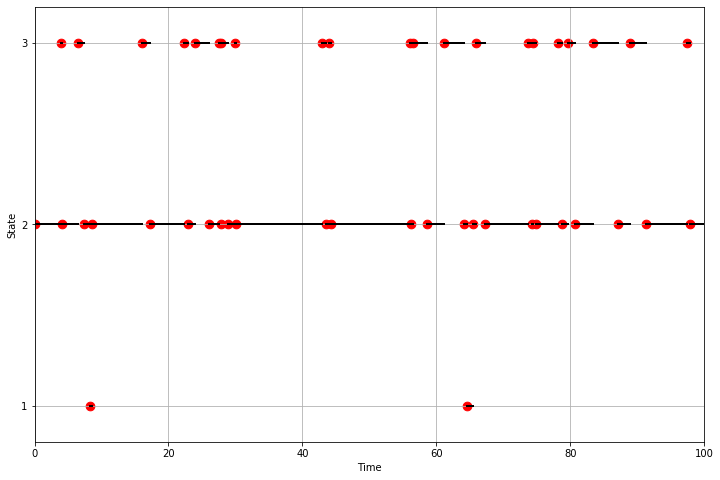

In [5]:
#inputs
G = np.array([[-2,1,1],[1,-4,3],[0,1,-1]])
tmax = 100
IC = 2

#run function
J,Y = ThreeStateCTMC(G, tmax, IC)

#plot the jumps 

#matplotlib inline
plt.figure(figsize = (12,8))
plt.grid()
plt.xlabel('Time')
plt.ylabel('State')
plt.xlim([0,tmax])
plt.ylim([0.8,3.2])
plt.yticks([1,2,3])
for j in range(0,len(J)-1):
    plt.plot([J[j],J[j+1]], [Y[j],Y[j]],'k',lw=2)
plt.scatter(J, Y,s=75,color='r')


#### Question 3(a)

Draw 1000 samples from a 2D multivariate (bivariate) Gaussian distribution.

Rather than plotting the 2D histogram, I just display the samples in the 2D plane and overlay the theoretical PDF (in the form of contour lines).

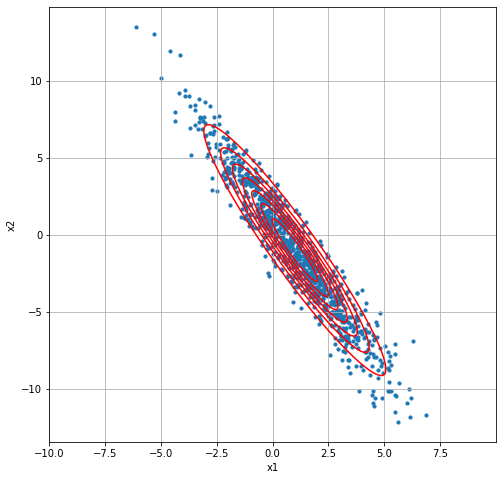

In [6]:
#define parameters
mu1 = 1
mu2 = -1
mu = np.array([mu1,mu2])

sig11 = 2
sig22 = 4
rho12 = -0.95  #must be in [0,1]
sigma = np.array([[sig11**2,rho12*sig11*sig22],[rho12*sig11*sig22,sig22**2]])

samples = np.random.multivariate_normal(mu,sigma,1000)

plt.figure(figsize = (8,8))
plt.grid()
#plt.hist2d(samples[:,0],samples[:,1],bins=50,density=False)
plt.scatter(samples[:,0],samples[:,1],s=10)
plt.xlabel("x1")
plt.ylabel("x2")

X1,X2 = np.mgrid[-10:10:.01, -10:10:.01]
pos = np.dstack((X1,X2))
rv = multivariate_normal(mu,sigma)
plt.contour(X1,X2,rv.pdf(pos),colors='r')
plt.show()


Next we can observe the marginal distributions of $X_1$ and $X_2$ respectively - also we can overlay the theoretical marginal distributions. 

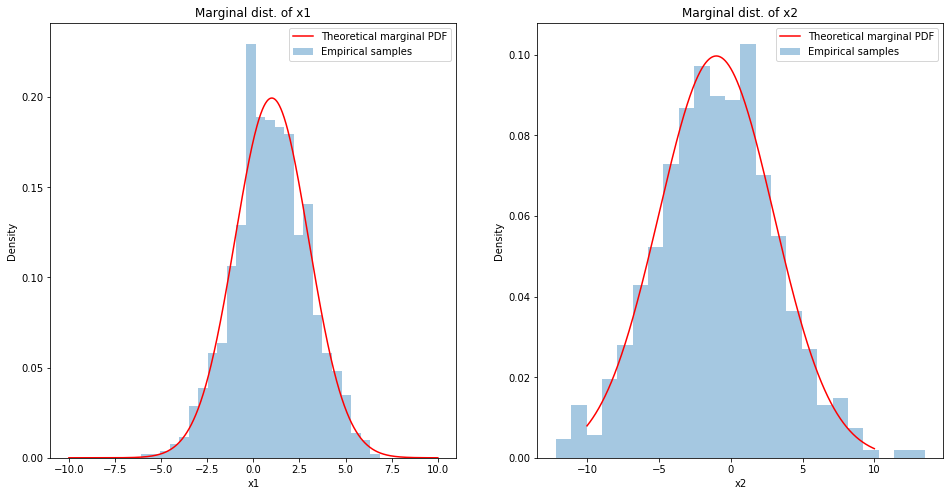

In [7]:
# for theoretical pdfs
x1 = np.linspace(-10,10, 1000)
x2 = np.linspace(-10,10, 1000)



plt.figure(figsize = (16,8))

plt.subplot(1,2,1)
sns.distplot(samples[:,0],kde=False,norm_hist=True,label='Empirical samples')
plt.plot(x1,norm.pdf(x1,mu1,sig11),'r', label='Theoretical marginal PDF')
plt.title('Marginal dist. of x1')
plt.xlabel("x1")
plt.ylabel("Density")
plt.legend()

plt.subplot(1,2,2)
sns.distplot(samples[:,1],kde=False,norm_hist=True,label='Empirical samples')
plt.plot(x2,norm.pdf(x2,mu2,sig22),'r', label='Theoretical marginal PDF')
plt.title('Marginal dist. of x2')
plt.xlabel("x2")
plt.ylabel("Density")
plt.legend()


#### Question 4(d)

For $\sigma^2=1$, choose $\mu=-1/2$ and two other values $\mu<-1/2$ and $\mu>-1/2$. Simulate and plot a few sample paths of the process with $Y_0=1$ up to time $t=10$, by numerically integrating the corresponding SDE with time steps $\Delta t=0.1$ and $0.01$.

We want to numerically integrate an SDE of the form:

$$ d Y_t = a(Y_t,t) dt + b(Y_t,t) dB_t,$$

where $a(Y_t,t) = (\mu + \sigma^2/2)Y_t$ and $b(Y_t,t) = \sigma Y_t$.

In [8]:
#input parameters

#different mean values (fixed sigma)
μ1 = -1
μ2 = -0.5
μ3 = -0.1
σ = 1

#initial condition
Y0 = 1

#maximum time to integrate until
tmax = 10

#time step
dt = 0.1

# vector of times
times = np.arange(0,tmax,dt) 

First define functions for both $a(Y_t,t)$ and $b(Y_t,t)$. Note I define three functions for $a(Y_t,t)$ each with a different value for $\mu$.

In [9]:
def a1(y,t):
    return (μ1 + (σ**2)/2)*y

def a2(y,t):
    return (μ2 + (σ**2)/2)*y

def a3(y,t):
    return (μ3 + (σ**2)/2)*y

def b(y,t):
    return σ*y

Next we integrate the SDEs using the sdeint library (https://pypi.org/project/sdeint/). You can write your own simple integration functions but this may take some time.

In [10]:
import sdeint #may need to install this on your laptops: sudo pip3 install sdeint

#it takes the two functions a and b, the initial condition and the time vector. 
result1 = sdeint.itoint(a1, b, Y0, times)
result2 = sdeint.itoint(a2, b, Y0, times)
result3 = sdeint.itoint(a3, b, Y0, times)

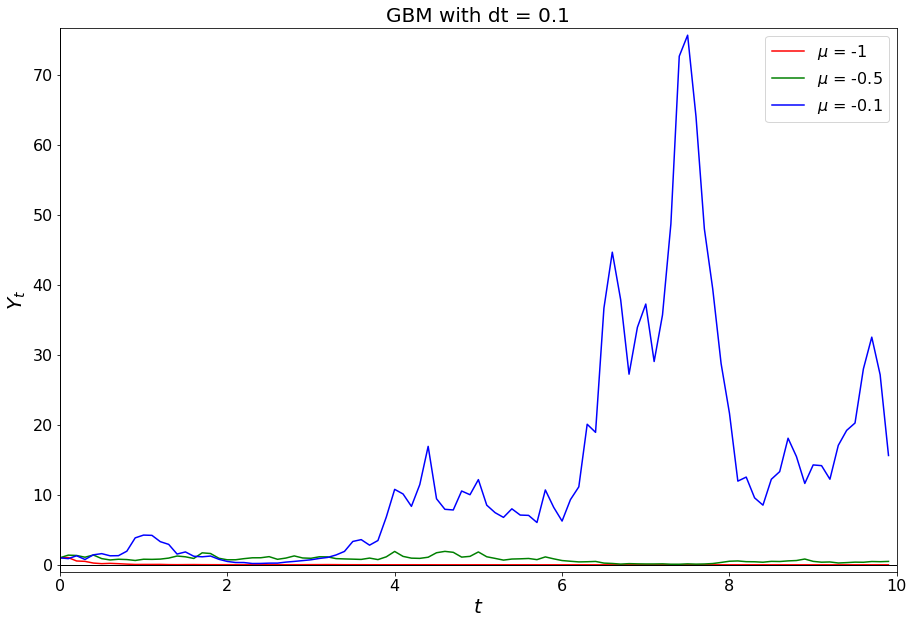

In [11]:
plt.figure(figsize = (15,10))
plt.plot(times, result1,'r',label = '$\mu$ = {}'.format(μ1))
plt.plot(times, result2,'g',label = '$\mu$ = {}'.format(μ2))
plt.plot(times, result3,'b',label = '$\mu$ = {}'.format(μ3))


plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$Y_t$', fontsize = 20)
plt.title('GBM with dt = {}'.format(dt), fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.axhline(linewidth=1, color='k')
plt.axvline(linewidth=1, color='k')
plt.axis([0, tmax,min(min(result1),min(result2),min(result3))-1,max(max(result1),max(result2),max(result3))+1])
plt.legend(loc = 'upper right', prop={'size': 16})

Change the time step to $\Delta t = 0.01$.

In [12]:
#time step
dt = 0.01

# vector of times
times = np.arange(0,tmax,dt) 

In [13]:
#it takes the two functions a and b, the initial condition and the time vector. 
result4 = sdeint.itoint(a1, b, Y0, times)
result5 = sdeint.itoint(a2, b, Y0, times)
result6 = sdeint.itoint(a3, b, Y0, times)

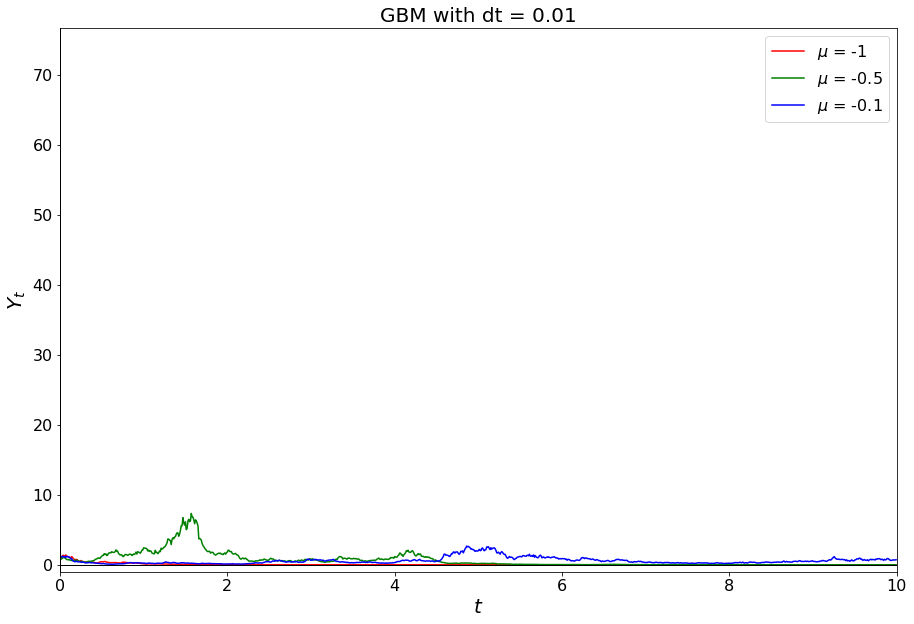

In [14]:
plt.figure(figsize = (15,10))
plt.plot(times, result4,'r',label = '$\mu$ = {}'.format(μ1))
plt.plot(times, result5,'g',label = '$\mu$ = {}'.format(μ2))
plt.plot(times, result6,'b',label = '$\mu$ = {}'.format(μ3))


plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$Y_t$', fontsize = 20)
plt.title('GBM with dt = {}'.format(dt), fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.axhline(linewidth=1, color='k')
plt.axvline(linewidth=1, color='k')
plt.axis([0, tmax,min(min(result1),min(result2),min(result3))-1,max(max(result1),max(result2),max(result3))+1])
plt.legend(loc = 'upper right', prop={'size': 16})

#### Question 5(a)(i) - Fractional Brownian Motion (FBM)

Fractal Brownian motion (FBM) is a generalization of Brownian motion such that
- increments of FBM need not be independent
- FBM is a continuous-time Gaussian process $B_H(t)$ on $[0, T]$
- the expectation of $B_H(t)$ is zero for all t in $[0, T]$
- the covariance function is given by $\mathbb{E} \left( B_H(t) B_H(s) \right) = \frac{1}{2} \left( |t|^{2H} + |s|^{2H} - |t-s|^{2H} \right) $ where $H \in (0,1)$ is the Hurst index.
- the increment process: $X(t) = B_H(t+1) − B_H(t)$, is known as fractional Gaussian noise (FGN).

Note that for the Hurst index: 
- If $H = 1/2$ then the process is simply a Brownian motion or Wiener process.
- If $H > 1/2$ then the increments of the process are positively correlated.
- If $H < 1/2$ then the increments of the process are negatively correlated.

To simulate FBM, we need to install [fbm](https://pypi.org/project/fbm/) (may need to install locally using `pip install fbm`): 
- **Fractional Brownian Motion**: Exact methods for simulating FBM or FGN in python.
- **Multifractional Brownian Motion**: Approximate simulation of multifractional Brownian motion (mBm) or multifractional Gaussian noise (mGn).


In [15]:
from fbm import FBM

In [22]:
# n is number of equispaced increments desired for a FBM
n = 2500

# set Hurst index 
hurst = 0.9

# set [0,T]
T = 1

f = FBM(n,hurst,T,method='daviesharte')
# method can either be 'hosking', 'cholesky', or 'daviesharte' (pick any)
# Note: can fail if Hurst is close to 1 or n is small

# generate a realisationof the FBM 
fbm_sample = f.fbm()

# get the times associated with the fBm
t_values = f.times()

(array([-0.25, -0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,
         0.2 ]), <a list of 10 Text yticklabel objects>)

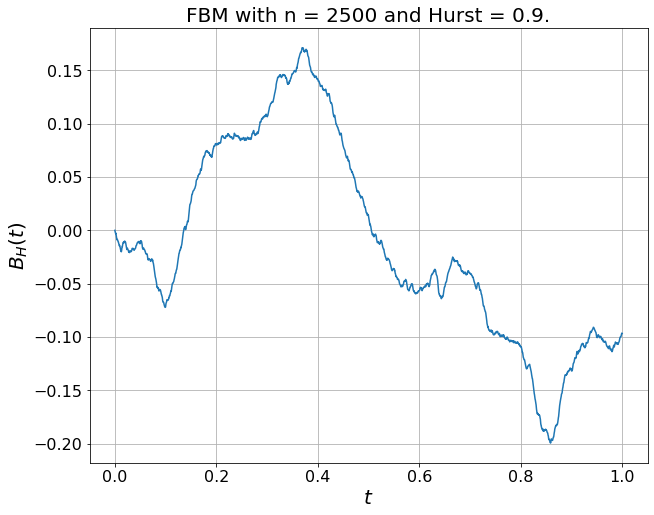

In [23]:
#plot the process
plt.figure(figsize=(10,8))
plt.plot(t_values, fbm_sample)
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$B_H (t)$', fontsize = 20)
plt.grid()
plt.title(r'FBM with n = {} and Hurst = {}.'.format(n,hurst), fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

#### Question 5(a)(ii) - Brownian Bridge (BB)

This is a Gaussian process which is "pinned" at the same value at the end time as it is at the start. It's essentially a GP with mean function $\mu(t)=0$ and covariance function $k(s,t) = \text{min} \{s,t\}-ts$.


In [24]:
#vector of time points
tmax = 1
dt = 0.01
times = np.arange(0,tmax+dt,dt) 

#mean vector
μ = np.zeros(len(times))

#covariance function (generates covariance matrix)
def k(s,t):
    grid = np.meshgrid(s,t)
    C = np.minimum(grid[0],grid[1]) - np.multiply(grid[0],grid[1])
    return C

#covariance matrix
C = k(times,times)

#take a sample from a multivariate Gaussian to simulate the BB process
samples = np.random.multivariate_normal(μ,C,1)


(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 <a list of 8 Text yticklabel objects>)

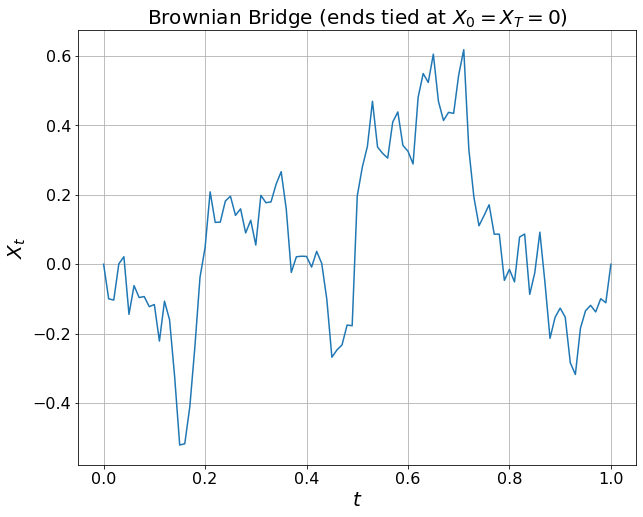

In [25]:
#plot the process
plt.figure(figsize=(10,8))
plt.plot(times,samples[0,:])
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$X_t$', fontsize = 20)
plt.grid()
plt.title(r'Brownian Bridge (ends tied at $X_0=X_T=0$)'.format(n,hurst), fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

#### Question 5(b)

Simulate a GP of your choice. 

Use the code above from the BB example to plot a GP with a given mean function and covariance function.

#### Question 5(c)

Consider the Metropolis-Hasting MCMC algorithm (lecture 5, slide 19-20) but with acceptance probability:

$$ a(x,y) = \big( 1 + \frac{\pi(c) q(x,y)}{\pi(y)q(y,x)} \big)^{-1}.$$

Show the scheme is reverisble with respect to $\pi$. 

Solution: For this, you just need to show that $\pi(x)p(x,y) = \pi(y)p(y,x)$.